# Per-gridpoint time correlation of two models

We've had a few questions lately about how to calculate a time correlation of two different models at every grid point. Numpy's `apply_along_axis()` function is super useful for applying a function to the time axis at each grid point of a single array, but what if we have more than one input array we need to do a calculation on?

To accomplish this we can use a trick - we can combine all the input arrays into a single big array that we can call `apply_along_axis()` on, and use a helper function to split the time axis of the big array back into its component pieces.

Let's start out by loading a couple libraries and turning on inline plotting

In [1]:
%matplotlib inline

import xarray
import numpy
import matplotlib.pyplot as plt

---

I've set up the function below to help do the correlation analysis. This works just like numpy's `apply_along_axis()` function, but instead of a single array it takes a list of arrays. These will all need to be the same dimension and the same size in all dimensions except time (they should also use the same grid latitudes and longitudes, but this isn't enforced by the function).

The function is split up into a few parts:

First all of the input arrays are concatenated along the axis of interest into `carrs`, which is the big array that gets used in `apply_along_axis()`.

Next I calculate the offsets needed to give to `split()` to undo the calculation. This only needs to be done once, as the offsets will be the same for every grid point. The offsets are calculated by adding together the lengths of each input array along the time axis.

After calculating the offsets I define a helper function which will split a single grid point's time axis from `carrs` into the individual input arrays. After splitting up the arrays it calls the user supplied function on all of the inputs.

Finally I pass `carrs` and the helper function to `apply_along_axis()`, which will in turn run the supplied function on the split arrays.

In [2]:
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = numpy.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = numpy.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return numpy.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)

---

To show off our function let's plot the correlation of the surface temperature of two CMIP5 models - HadGEM2-AO from KMA and HadGEM2-CC from the Hadley Centre. I've chosen the same model type just to make sure they're using the same grid, you could do an interpolation if the models were on different grids

In [3]:
a = xarray.open_dataset('/g/data/al33/replicas/CMIP5/combined/NIMR-KMA/HadGEM2-AO/historical/mon/atmos/Amon/r1i1p1/v20130815/tas/tas_Amon_HadGEM2-AO_historical_r1i1p1_186001-200512.nc')
b = xarray.open_mfdataset('/g/data/al33/replicas/CMIP5/combined/MOHC/HadGEM2-CC/historical/mon/atmos/Amon/r1i1p1/v20110927/tas/tas_Amon_HadGEM2-CC_historical_r1i1p1_*.nc')

a.tas

<xarray.DataArray 'tas' (time: 1752, lat: 145, lon: 192)>
[48775680 values with dtype=float32]
Coordinates:
  * time     (time) object 1860-01-16 00:00:00 ... 2005-12-16 00:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           near-surface (usually, 2 meter) air temperature.
    units:             K
    original_name:     TAS
    cell_methods:      time: mean (interval: 1 month)
    cell_measures:     area: areacella
    history:           2012-08-10T03:38:23Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

---

For the correlation function I'm going to use the `pearsonr()` function from Scipy. This returns two values as a tuple - the Pearson correlation coefficient and the two-tailed p-value. When I apply the function these two values will be added as a new axis, replacing the time axis.

I'll apply it along the time axis, which for this example is axis 0. I'm also going to make sure the date range is the same for both inputs - the values for the full date range start and end in different months in each model.

In [4]:
from scipy.stats.stats import pearsonr

corr = multi_apply_along_axis(pearsonr, 0, [a.tas.sel(time=slice('1960','1990')), b.tas.sel(time=slice('1960','1990'))])
corr.shape

(2, 145, 192)

---

Now let's plot the results. I've done a log of the p-value to better show off its range.

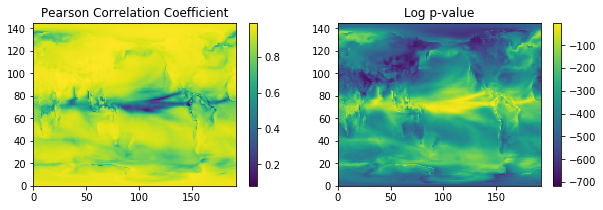

In [5]:
fig, axes = plt.subplots(1,2, figsize=(10,3))

p0 = axes[0].pcolormesh(corr[0,:,:])
plt.colorbar(p0, ax=axes[0])
axes[0].set_title('Pearson Correlation Coefficient')

p1 = axes[1].pcolormesh(numpy.log(corr[1,:,:]))
axes[1].set_title('Log p-value')
plt.colorbar(p1, ax=axes[1])

---

If the dimensions of the input arrays aren't compatible (say if we try to compare different regions) Numpy will raise an exception when it attempts the concatenation

In [6]:
a_subset = a.tas.isel(lat=slice(0,50))

corr = multi_apply_along_axis(pearsonr, 0, [a_subset.sel(time=slice('1960','1990')), b.tas.sel(time=slice('1960','1990'))])

ValueError: all the input array dimensions except for the concatenation axis must match exactly